<a href="https://colab.research.google.com/github/mattfarrow1/7331-machine-learning-1/blob/main/Labs/Lab1_Group4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab One: Visualization and Data Preprocessing

Matt Farrow, Amber Clark, Blake Freeman, Megan Ball

## **2015 Flight Delays and Cancellations**
Data Source: [Kaggle](https://www.kaggle.com/usdot/flight-delays?select=flights.csv)

## Business Understanding

#### <font color='red'>Feedback: Great!</font>

The data set that our group selected came the U.S. Department of Transportation's Bureau of Transportation Statistics and "tracks the on-time performance of domestic flights operated by large air carriers" during 2015 ([Kaggle](https://www.kaggle.com/usdot/flight-delays)). The data is broken up into three separate `.csv` files: one with flight details for 5,819,079 flights during 2015, one with 14 different U.S.-based airlines, and one with the geographic details of 322 U.S. airports. 

The data is important because it takes airline delays and cancellations, one of the aspects of airline travel that is popular fodder for public complaints, and quantifies it in a way that offers the possiblity of tangible analysis. For the purposes of this analysis, the two variables that we intend to measure are `ARRIVAL_DELAY` and `CANCELLATION`. 

### Arrival Delay

Although the data set contains a number of features related to when flights departed, delays, and air times, we made the decision that the most important feature for customers is the arrival delay. Arrival delay serves as the total delay experienced by the flight and accounts for previous delays as well as time that pilots were able to make up in the air. 

Becase arrival delay is a numeric value, regression and RMSE will be used to model and measure the feature. The model's effectiveness will measured using 10-fold cross-validation. 

### Cancellation

Cancellation is the other feature of interest. There are a number of reasons that a flight would be cancelled including airline cancellations, weather,national air system, and security reasons. 

This feature will be modeled using classification with accuracy being the primary measure. As with arrival delay, cancellation's effectiveness will be measured using 10-fold cross-validation.

## Data Meaning Type

#### <font color='red'>Feedback: Good!</font>

The data, published in the Department of Transportation's Bureau of Statistics comprises three data files: `flights.csv`, `airlines.csv`, and `airport.csv`.

### Flights

The file contains 31 attributes consisting of 8 integers, 12 objects, and 11 floats.

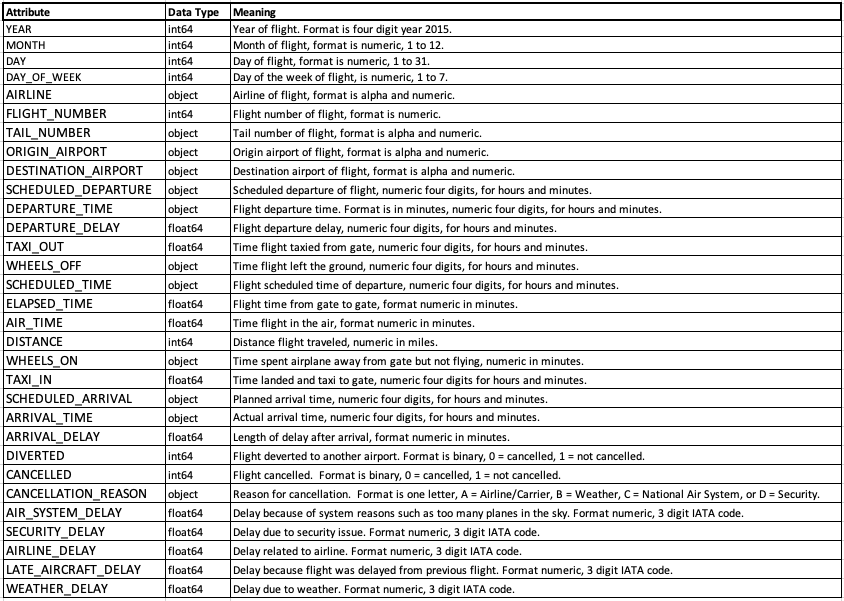

### Airports

The file contains 7 attributes consisting of 5 objects and 2 floats.

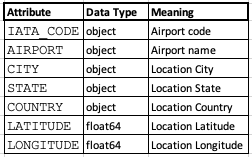

### Airlines

The file contains 2 object attributes.

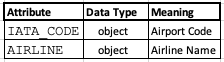

### Load the Data

In [1]:
# Load libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
import altair as alt

In [2]:
# Due to the way these columns are formatted, we want to keep the leading zeros during our import. Later on will convert them to a time format.
dtype_t = {'SCHEDULED_DEPARTURE': str,
           'DEPARTURE_TIME': str,
           'WHEELS_OFF': str,
           'SCHEDULED_TIME': str,
           'WHEELS_ON': str,
           'SCHEDULED_ARRIVAL': str,
           'ARRIVAL_TIME': str
          }

# Read in the data directly
# Read in the data using Pandas
airlines = pd.read_csv('../Data/airlines.csv')
airports = pd.read_csv('../Data/airports.csv')
flights  = pd.read_csv('../Data/flights.csv', dtype = dtype_t)

# Read in the data directly from GitHub
# airlines = pd.read_csv('https://raw.githubusercontent.com/mattfarrow1/7331-machine-learning-1/main/Data/airlines.csv')
# airports = pd.read_csv('https://raw.githubusercontent.com/mattfarrow1/7331-machine-learning-1/main/Data/airports.csv')
# flights  = pd.read_csv('https://media.githubusercontent.com/media/mattfarrow1/7331-machine-learning-1/main/Data/flights.csv', dtype = dtype_t)

/Users/mattfarrow/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Look at the airline data
airlines.head()

IATA_CODE                 AIRLINE
0        UA   United Air Lines Inc.
1        AA  American Airlines Inc.
2        US         US Airways Inc.
3        F9  Frontier Airlines Inc.
4        B6         JetBlue Airways

In [4]:
# Look at the airport data
airports.head()

IATA_CODE                              AIRPORT         CITY STATE COUNTRY  \
0       ABE  Lehigh Valley International Airport    Allentown    PA     USA   
1       ABI             Abilene Regional Airport      Abilene    TX     USA   
2       ABQ    Albuquerque International Sunport  Albuquerque    NM     USA   
3       ABR            Aberdeen Regional Airport     Aberdeen    SD     USA   
4       ABY   Southwest Georgia Regional Airport       Albany    GA     USA   

   LATITUDE  LONGITUDE  
0  40.65236  -75.44040  
1  32.41132  -99.68190  
2  35.04022 -106.60919  
3  45.44906  -98.42183  
4  31.53552  -84.19447

In [5]:
# Look at the flight data
flights.head()

YEAR  MONTH  DAY  DAY_OF_WEEK AIRLINE  FLIGHT_NUMBER TAIL_NUMBER  \
0  2015      1    1            4      AS             98      N407AS   
1  2015      1    1            4      AA           2336      N3KUAA   
2  2015      1    1            4      US            840      N171US   
3  2015      1    1            4      AA            258      N3HYAA   
4  2015      1    1            4      AS            135      N527AS   

  ORIGIN_AIRPORT DESTINATION_AIRPORT SCHEDULED_DEPARTURE  ... ARRIVAL_TIME  \
0            ANC                 SEA                0005  ...         0408   
1            LAX                 PBI                0010  ...         0741   
2            SFO                 CLT                0020  ...         0811   
3            LAX                 MIA                0020  ...         0756   
4            SEA                 ANC                0025  ...         0259   

   ARRIVAL_DELAY  DIVERTED CANCELLED CANCELLATION_REASON  AIR_SYSTEM_DELAY  \
0          -22.0         0         0                 NaN               NaN   
1           -9.0         0         0                 NaN               NaN   
2            5.0         0         0                 NaN               NaN   
3           -9.0         0         0                 NaN               NaN   
4          -21.0         0         0                 NaN               NaN   

   SECURITY_DELAY  AIRLINE_DELAY LATE_AIRCRAFT_DELAY  WEATHER_DELAY  
0             NaN            NaN                 NaN            NaN  
1             NaN            NaN                 NaN            NaN  
2             NaN            NaN                 NaN            NaN  
3             NaN            NaN                 NaN            NaN  
4             NaN            NaN                 NaN            NaN  

[5 rows x 31 columns]

### Merge Flights & Airlines

The flight data will become our primary data set, but we can join it with the airline information to bring in the human-readable names.

In [6]:
# Rename columns in preparation for merge
airlines.rename(columns={'IATA_CODE': 'AIRLINE_CODE'}, inplace=True)
flights.rename(columns={'AIRLINE': 'AIRLINE_CODE'}, inplace=True)

In [7]:
# Merge data together
df = pd.merge(flights, airlines, on='AIRLINE_CODE', how = 'left')

In [8]:
# Look at the newly merged data
pd.set_option('display.max_columns', None)
df.head()

YEAR  MONTH  DAY  DAY_OF_WEEK AIRLINE_CODE  FLIGHT_NUMBER TAIL_NUMBER  \
0  2015      1    1            4           AS             98      N407AS   
1  2015      1    1            4           AA           2336      N3KUAA   
2  2015      1    1            4           US            840      N171US   
3  2015      1    1            4           AA            258      N3HYAA   
4  2015      1    1            4           AS            135      N527AS   

  ORIGIN_AIRPORT DESTINATION_AIRPORT SCHEDULED_DEPARTURE DEPARTURE_TIME  \
0            ANC                 SEA                0005           2354   
1            LAX                 PBI                0010           0002   
2            SFO                 CLT                0020           0018   
3            LAX                 MIA                0020           0015   
4            SEA                 ANC                0025           0024   

   DEPARTURE_DELAY  TAXI_OUT WHEELS_OFF SCHEDULED_TIME  ELAPSED_TIME  \
0            -11.0      21.0       0015            205         194.0   
1             -8.0      12.0       0014            280         279.0   
2             -2.0      16.0       0034            286         293.0   
3             -5.0      15.0       0030            285         281.0   
4             -1.0      11.0       0035            235         215.0   

   AIR_TIME  DISTANCE WHEELS_ON  TAXI_IN SCHEDULED_ARRIVAL ARRIVAL_TIME  \
0     169.0      1448      0404      4.0              0430         0408   
1     263.0      2330      0737      4.0              0750         0741   
2     266.0      2296      0800     11.0              0806         0811   
3     258.0      2342      0748      8.0              0805         0756   
4     199.0      1448      0254      5.0              0320         0259   

   ARRIVAL_DELAY  DIVERTED  CANCELLED CANCELLATION_REASON  AIR_SYSTEM_DELAY  \
0          -22.0         0          0                 NaN               NaN   
1           -9.0         0          0                 NaN               NaN   
2            5.0         0          0                 NaN               NaN   
3           -9.0         0          0                 NaN               NaN   
4          -21.0         0          0                 NaN               NaN   

   SECURITY_DELAY  AIRLINE_DELAY  LATE_AIRCRAFT_DELAY  WEATHER_DELAY  \
0             NaN            NaN                  NaN            NaN   
1             NaN            NaN                  NaN            NaN   
2             NaN            NaN                  NaN            NaN   
3             NaN            NaN                  NaN            NaN   
4             NaN            NaN                  NaN            NaN   

                  AIRLINE  
0    Alaska Airlines Inc.  
1  American Airlines Inc.  
2         US Airways Inc.  
3  American Airlines Inc.  
4    Alaska Airlines Inc.

In [9]:
df.shape

(5819079, 32)

Our merged data set contains 5,819,079 observations and 32 attributes.

### Convert String Columns to Datetime

In [10]:
cols = ["SCHEDULED_DEPARTURE", 
   "DEPARTURE_TIME", 
   "WHEELS_OFF",  
   "WHEELS_ON", 
   "SCHEDULED_ARRIVAL", 
   "ARRIVAL_TIME"]

df[cols] = df[cols].apply(pd.to_datetime, format = '%H%M', errors='coerce')

In [11]:
df[["SCHEDULED_DEPARTURE", 
   "DEPARTURE_TIME", 
   "WHEELS_OFF", 
   "WHEELS_ON", 
   "SCHEDULED_ARRIVAL", 
   "ARRIVAL_TIME"]].head()

SCHEDULED_DEPARTURE      DEPARTURE_TIME          WHEELS_OFF  \
0 1900-01-01 00:05:00 1900-01-01 23:54:00 1900-01-01 00:15:00   
1 1900-01-01 00:10:00 1900-01-01 00:02:00 1900-01-01 00:14:00   
2 1900-01-01 00:20:00 1900-01-01 00:18:00 1900-01-01 00:34:00   
3 1900-01-01 00:20:00 1900-01-01 00:15:00 1900-01-01 00:30:00   
4 1900-01-01 00:25:00 1900-01-01 00:24:00 1900-01-01 00:35:00   

            WHEELS_ON   SCHEDULED_ARRIVAL        ARRIVAL_TIME  
0 1900-01-01 04:04:00 1900-01-01 04:30:00 1900-01-01 04:08:00  
1 1900-01-01 07:37:00 1900-01-01 07:50:00 1900-01-01 07:41:00  
2 1900-01-01 08:00:00 1900-01-01 08:06:00 1900-01-01 08:11:00  
3 1900-01-01 07:48:00 1900-01-01 08:05:00 1900-01-01 07:56:00  
4 1900-01-01 02:54:00 1900-01-01 03:20:00 1900-01-01 02:59:00

### Convert YEAR, MONTH, DAY into a Single Date

In [12]:
# Source: https://stackoverflow.com/questions/54487059/pandas-how-to-create-a-single-date-column-from-columns-containing-year-month
df['FLIGHT_DATE'] = pd.to_datetime([f'{y}-{m}-{d}' for y, m, d in zip(df.YEAR, df.MONTH, df.DAY)])

## Data Quality

#### <font color='red'>Feedback: Nice job!</font>

### Missing Values

In [13]:
# How many missing values are there in the data?
df.isnull().sum()

YEAR                         0
MONTH                        0
DAY                          0
DAY_OF_WEEK                  0
AIRLINE_CODE                 0
FLIGHT_NUMBER                0
TAIL_NUMBER              14721
ORIGIN_AIRPORT               0
DESTINATION_AIRPORT          0
SCHEDULED_DEPARTURE          0
DEPARTURE_TIME           86666
DEPARTURE_DELAY          86153
TAXI_OUT                 89047
WHEELS_OFF               89774
SCHEDULED_TIME               6
ELAPSED_TIME            105071
AIR_TIME                105071
DISTANCE                     0
WHEELS_ON                94518
TAXI_IN                  92513
SCHEDULED_ARRIVAL            2
ARRIVAL_TIME             94969
ARRIVAL_DELAY           105071
DIVERTED                     0
CANCELLED                    0
CANCELLATION_REASON    5729195
AIR_SYSTEM_DELAY       4755640
SECURITY_DELAY         4755640
AIRLINE_DELAY          4755640
LATE_AIRCRAFT_DELAY    4755640
WEATHER_DELAY          4755640
AIRLINE                      0
FLIGHT_D

There are millions of missing values in the specific delay time columns. This is expected, as not every flight is delayed, and you would hope that percentage would be small of the overall flights. 

Similar to the delay columns, the `CANCELLATION_REASON` column also contains millions of missing values. Here we convert the missing values to `N`.

In [14]:
# Convert missing values to 'N' for 'N/A'
df['CANCELLATION_REASON'] = df['CANCELLATION_REASON'].fillna('N')

# Source: datagy.io/pandas-get-dummies/
# One hot encode - removing to save memory

#one_hot_columns = ['CANCELLATION_REASON']

#for column in one_hot_columns:
#  tempdf = pd.get_dummies(df[column], prefix=column)
#
#  df = pd.merge(
#      left = df,
#      right = tempdf,
#      left_index = True,
#      right_index = True,
#  )

#  df = df.drop(columns=column)

# df.head()

The remaining rows containing missing data now only account for about 2% of the total number of original observations. However, if we remove all of them, it also removes all of the cancelled flights as those are the ones with the missing values for arrival time and delay, as well as elapsed and air time as the flights never took off. 

To deal with these values, we will modify the `DEPARTURE_TIME`, `ARRIVAL TIME`, `WHEELS_OFF`, and `WHEELS_ON` into binary values where `0` means the flight never departed or arrived and `1` means that it did depart or arrive. First, we will replace all missing values for `0` as those never departed/arrived. Then the remaining values that are non-zero will be changed to `1`. Last, we will update the names for `DEPARTURE_TIME` and `ARRIVAL_TIME` into `DEPARTED` or `ARRIVED`.

In [15]:
# update missing values in times to 0. 
# Will be updating times to a binary (1 = yes action happened, 0 = no action happened)
df['DEPARTURE_TIME'] = df['DEPARTURE_TIME'].fillna(0)

# change all non-null values to 1
df.loc[(df.DEPARTURE_TIME != '0'), 'DEPARTURE_TIME'] = 1

# change column name to 'DEPARTED'
df.rename(columns={'DEPARTURE_TIME': 'DEPARTED'}, inplace=True)

In [16]:
# update remaining columns using same logic

cols = ['WHEELS_OFF','WHEELS_ON','ARRIVAL_TIME']
df[cols] = df[cols].fillna(0)

df.loc[(df.WHEELS_OFF != '0'), 'WHEELS_OFF'] = 1
df.loc[(df.WHEELS_ON != '0'), 'WHEELS_ON'] = 1
df.loc[(df.ARRIVAL_TIME != '0'), 'ARRIVAL_TIME'] = 1

df.rename(columns={'ARRIVAL_TIME': 'ARRIVED'}, inplace=True)

Now, the majority of our missing values are for `AIR_SYSTEM_DELAY`, `SECURITY_DELAY`, `AIRLINE_DELAY`, `LATE_AIRCRAFT_DELAY`, and `WEATHER DELAY`.  We will change these missing values to `0` because if the flight was NOT cancelled, and these values are missing, then there was NO delay.

In [17]:
#fill missing values with 0
cols = ['AIR_SYSTEM_DELAY','SECURITY_DELAY','AIRLINE_DELAY','LATE_AIRCRAFT_DELAY','WEATHER_DELAY']
df[cols] = df[cols].fillna(0)

After imputing these values, the bulk of our missing values are `DEPARTURE_DELAY`, `TAXI_OUT`, `ELAPSED_TIME`, `AIR_TIME`, `TAXI_IN`, and `ARRIVAL_DELAY`. If the flight was cancelled, all of these values are actually zero because they never occurred. We will make this modification next.

In [18]:
#change remaining null values to 0 if flight was cancelled
df.loc[(df.CANCELLED == 1), ('DEPARTURE_DELAY', 'TAXI_OUT', 'ELAPSED_TIME','AIR_TIME','TAXI_IN','ARRIVAL_DELAY')] = 0
df.isna().sum()

YEAR                       0
MONTH                      0
DAY                        0
DAY_OF_WEEK                0
AIRLINE_CODE               0
FLIGHT_NUMBER              0
TAIL_NUMBER            14721
ORIGIN_AIRPORT             0
DESTINATION_AIRPORT        0
SCHEDULED_DEPARTURE        0
DEPARTED                   0
DEPARTURE_DELAY            0
TAXI_OUT                   0
WHEELS_OFF                 0
SCHEDULED_TIME             6
ELAPSED_TIME           15187
AIR_TIME               15187
DISTANCE                   0
WHEELS_ON                  0
TAXI_IN                 2629
SCHEDULED_ARRIVAL          2
ARRIVED                    0
ARRIVAL_DELAY          15187
DIVERTED                   0
CANCELLED                  0
CANCELLATION_REASON        0
AIR_SYSTEM_DELAY           0
SECURITY_DELAY             0
AIRLINE_DELAY              0
LATE_AIRCRAFT_DELAY        0
WEATHER_DELAY              0
AIRLINE                    0
FLIGHT_DATE                0
dtype: int64

Now we only have about 15,000 rows max with missing values, which is << 0.1% of the data. We are comfortable now removing the rest of these values.

In [19]:
#remove remaining null value
df = df.dropna()

In [20]:
#save data here for faster upload on section
# df.to_csv('../Data/df_clean.csv.gz', index = False, compression = "gzip")

In [21]:
#re-load & check data
#df = pd.read_csv('../Data/df_clean.csv.gz', compression = "gzip")
#df.info()

### Duplicate Data

In [22]:
#check for duplicates
duplicate = df[df.duplicated()]
duplicate

Empty DataFrame
Columns: [YEAR, MONTH, DAY, DAY_OF_WEEK, AIRLINE_CODE, FLIGHT_NUMBER, TAIL_NUMBER, ORIGIN_AIRPORT, DESTINATION_AIRPORT, SCHEDULED_DEPARTURE, DEPARTED, DEPARTURE_DELAY, TAXI_OUT, WHEELS_OFF, SCHEDULED_TIME, ELAPSED_TIME, AIR_TIME, DISTANCE, WHEELS_ON, TAXI_IN, SCHEDULED_ARRIVAL, ARRIVED, ARRIVAL_DELAY, DIVERTED, CANCELLED, CANCELLATION_REASON, AIR_SYSTEM_DELAY, SECURITY_DELAY, AIRLINE_DELAY, LATE_AIRCRAFT_DELAY, WEATHER_DELAY, AIRLINE, FLIGHT_DATE]
Index: []

After addressing the missing values, we checked to see if there were any duplicated data in our data set. As displayed above no results came up after checking for any duplicated rows.

### Outliers

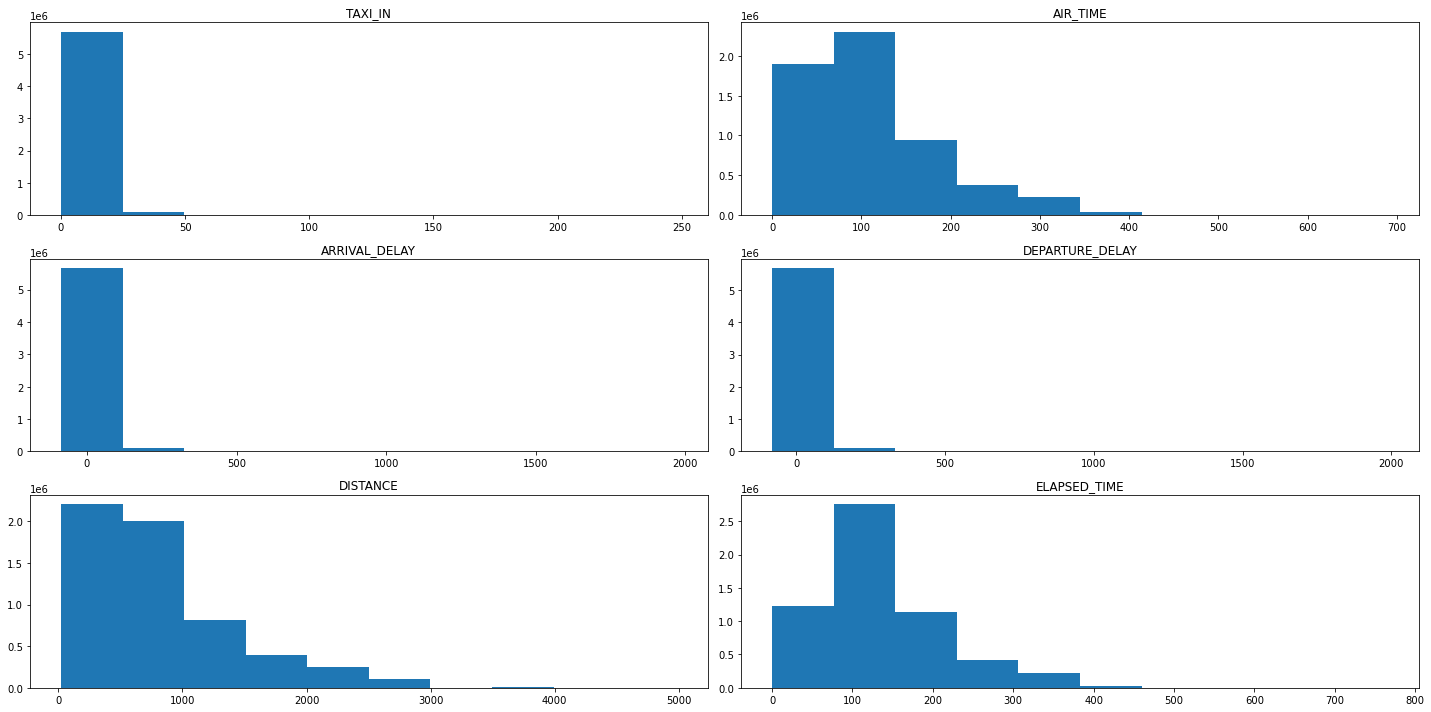

In [23]:
# Code: https://matplotlib.org/stable/gallery/statistics/histogram_multihist.html


fig, ((ax0, ax1), (ax2, ax3),(ax4, ax5)) = plt.subplots( figsize=(20,10),nrows=3, ncols=2)


ax0.hist(df["TAXI_IN"])
ax0.set_title('TAXI_IN')


ax1.hist(df["AIR_TIME"])
ax1.set_title('AIR_TIME')


ax2.hist(df["ARRIVAL_DELAY"])
ax2.set_title('ARRIVAL_DELAY')


ax3.hist(df["DEPARTURE_DELAY"])
ax3.set_title('DEPARTURE_DELAY')

ax4.hist(df["DISTANCE"])
ax4.set_title('DISTANCE')

ax5.hist(df["ELAPSED_TIME"])
ax5.set_title('ELAPSED_TIME')

fig.tight_layout()
plt.show()

The figures above indicate a right skew for all the variables listed above. 

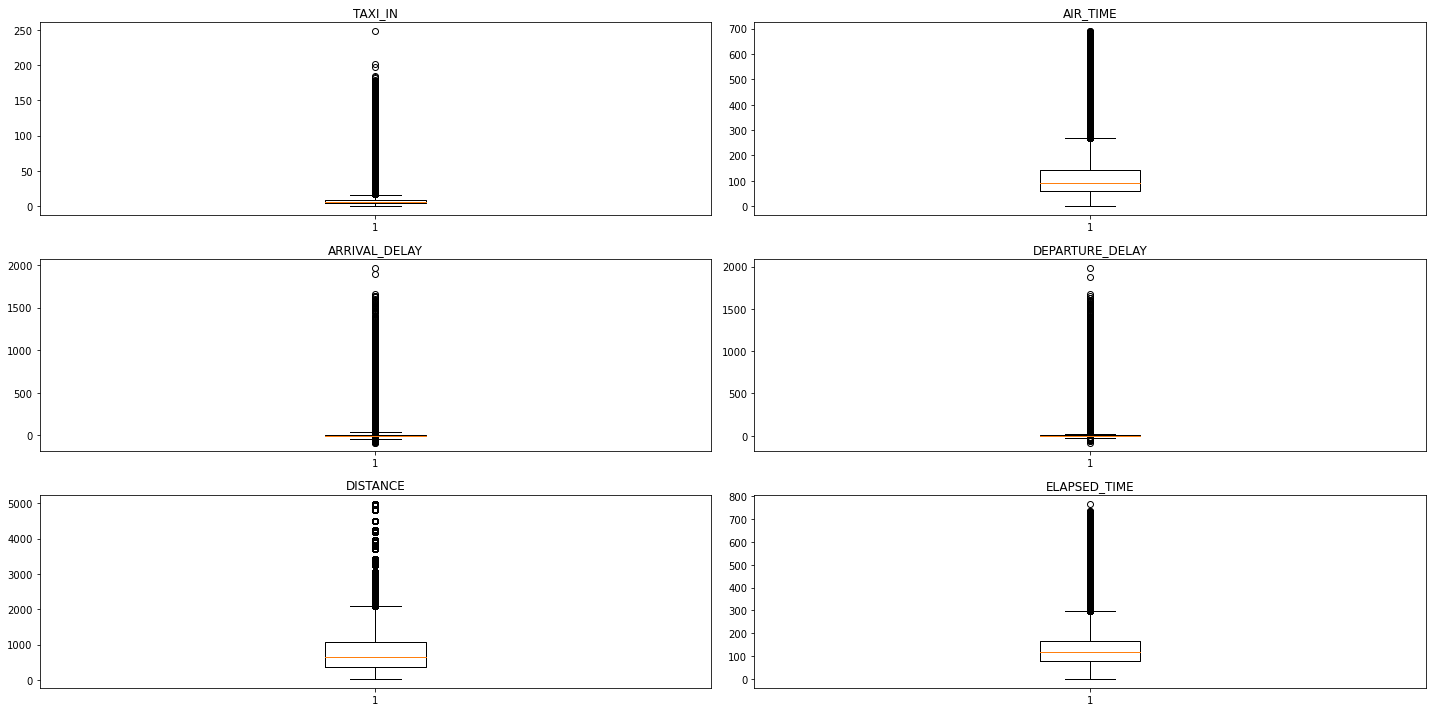

In [24]:
fig, ((ax0, ax1), (ax2, ax3),(ax4, ax5)) = plt.subplots( figsize=(20,10),nrows=3, ncols=2)


ax0.boxplot(df["TAXI_IN"])
ax0.set_title('TAXI_IN')


ax1.boxplot(df["AIR_TIME"])
ax1.set_title('AIR_TIME')


ax2.boxplot(df["ARRIVAL_DELAY"])
ax2.set_title('ARRIVAL_DELAY')


ax3.boxplot(df["DEPARTURE_DELAY"])
ax3.set_title('DEPARTURE_DELAY')

ax4.boxplot(df["DISTANCE"])
ax4.set_title('DISTANCE')

ax5.boxplot(df["ELAPSED_TIME"])
ax5.set_title('ELAPSED_TIME')

fig.tight_layout()
plt.show()

In addition to being righted skewed, all the outputs have a large amount of outliers present. To remove the right skew, it will be necessary to do a log transformation of the data set on these selected variables. 

In [25]:
# log transformation keeping the 0 in the data sets 
df["DEPARTURE_DELAY_log"] = df["DEPARTURE_DELAY"].map(lambda i: np.log1p(i) if i > 0 else 0) 
df["ARRIVAL_DELAY_Log"]   = df["ARRIVAL_DELAY"].map(lambda i: np.log1p(i) if i > 0 else 0)
df["DISTANCE_log"]        = df["DISTANCE"].map(lambda i: np.log1p(i) if i > 0 else 0) 
df["TAXI_IN_Log"]         = df["TAXI_IN"].map(lambda i: np.log1p(i) if i > 0 else 0)
df["ELAPSED_TIME_log"]    = df["ELAPSED_TIME"].map(lambda i: np.log1p(i) if i > 0 else 0) 
df["AIR_TIME_log"]        = df["AIR_TIME"].map(lambda i: np.log1p(i) if i > 0 else 0) 

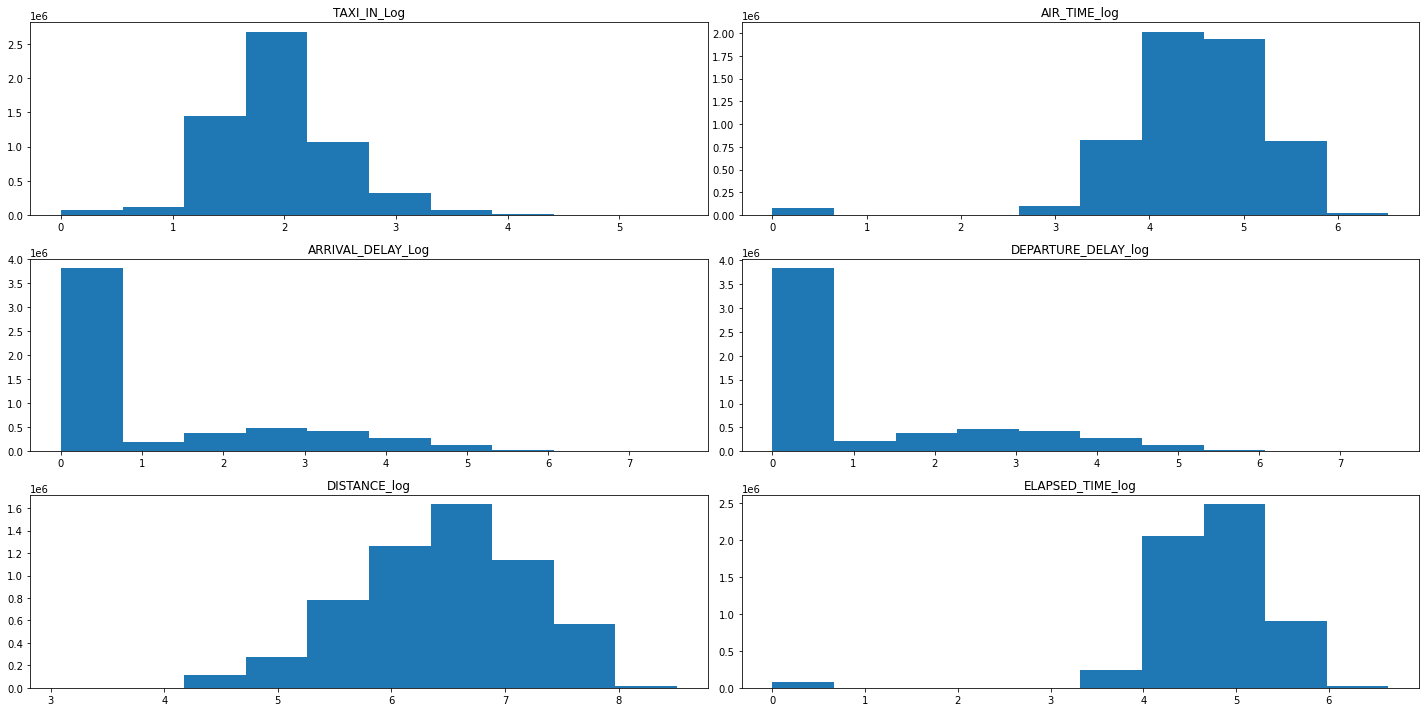

In [26]:
#Code: https://matplotlib.org/stable/gallery/statistics/histogram_multihist.html

fig, ((ax0, ax1), (ax2, ax3),(ax4, ax5)) = plt.subplots( figsize=(20,10),nrows=3, ncols=2)


ax0.hist(df["TAXI_IN_Log"])
ax0.set_title('TAXI_IN_Log')


ax1.hist(df["AIR_TIME_log"])
ax1.set_title('AIR_TIME_log')


ax2.hist(df["ARRIVAL_DELAY_Log"])
ax2.set_title('ARRIVAL_DELAY_Log')


ax3.hist(df["DEPARTURE_DELAY_log"])
ax3.set_title('DEPARTURE_DELAY_log')

ax4.hist(df["DISTANCE_log"])
ax4.set_title('DISTANCE_log')

ax5.hist(df["ELAPSED_TIME_log"])
ax5.set_title('ELAPSED_TIME_log')

fig.tight_layout()
plt.show()

After the log transformations we have more evenly distributed variables, however the `CANCELLED` variable which was  set at zero and used to populate missing data causes there to be an offset in the data set and stops full normalization of the data. 

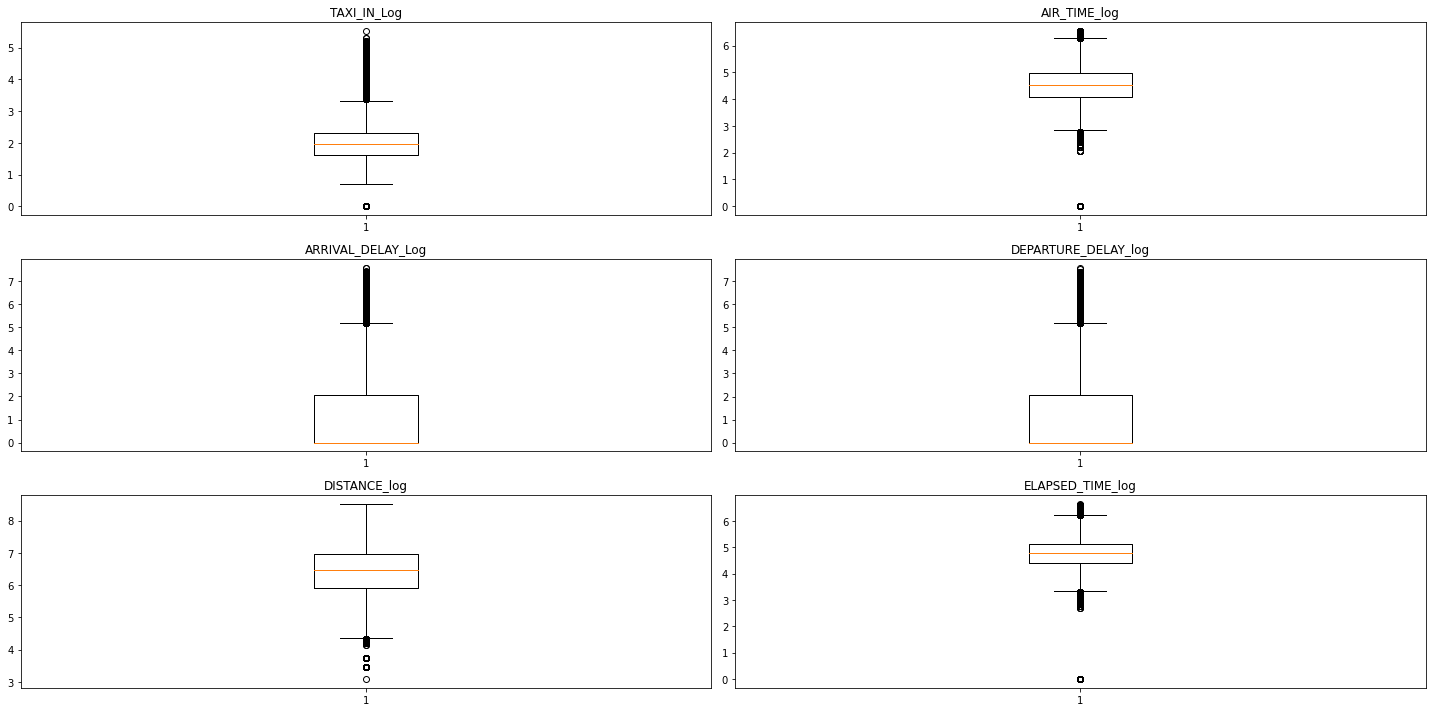

In [27]:
fig, ((ax0, ax1), (ax2, ax3),(ax4, ax5)) = plt.subplots( figsize=(20,10),nrows=3, ncols=2)


ax0.boxplot(df["TAXI_IN_Log"])
ax0.set_title('TAXI_IN_Log')


ax1.boxplot(df["AIR_TIME_log"])
ax1.set_title('AIR_TIME_log')


ax2.boxplot(df["ARRIVAL_DELAY_Log"])
ax2.set_title('ARRIVAL_DELAY_Log')


ax3.boxplot(df["DEPARTURE_DELAY_log"])
ax3.set_title('DEPARTURE_DELAY_log')

ax4.boxplot(df["DISTANCE_log"])
ax4.set_title('DISTANCE_log')

ax5.boxplot(df["ELAPSED_TIME_log"])
ax5.set_title('ELAPSED_TIME_log')

fig.tight_layout()
plt.show()

This figure above displays the distribution of still existing outliers after the log transformations. Next we will explore the data, removing the `0` values in arrival and departure delays. 

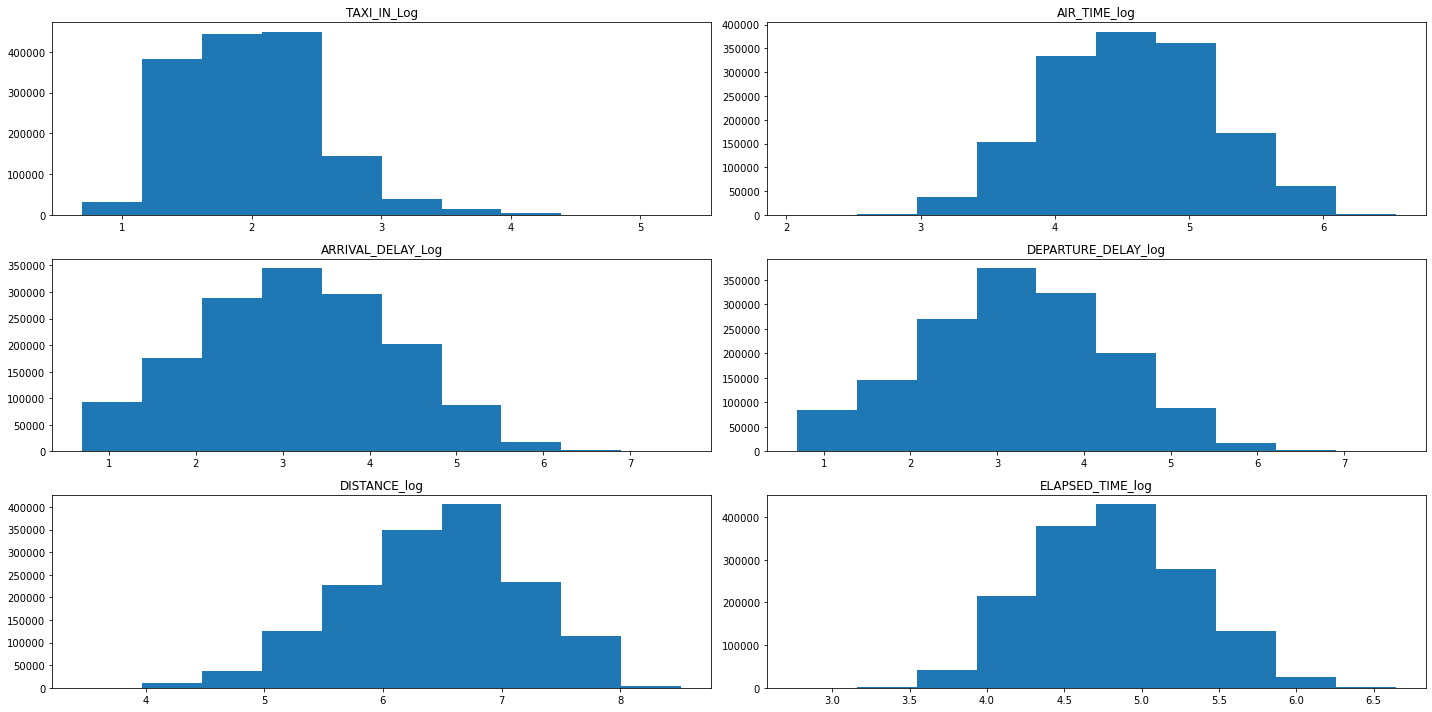

In [28]:
df_log_no_0 = df
df_log_no_0 = df_log_no_0[df_log_no_0['DEPARTURE_DELAY_log'] !=0]
df_log_no_0 = df_log_no_0[df_log_no_0['ARRIVAL_DELAY_Log'] !=0]

fig, ((ax0, ax1), (ax2, ax3),(ax4, ax5)) = plt.subplots( figsize=(20,10),nrows=3, ncols=2)


ax0.hist(df_log_no_0["TAXI_IN_Log"])
ax0.set_title('TAXI_IN_Log')


ax1.hist(df_log_no_0["AIR_TIME_log"])
ax1.set_title('AIR_TIME_log')


ax2.hist(df_log_no_0["ARRIVAL_DELAY_Log"])
ax2.set_title('ARRIVAL_DELAY_Log')


ax3.hist(df_log_no_0["DEPARTURE_DELAY_log"])
ax3.set_title('DEPARTURE_DELAY_log')

ax4.hist(df_log_no_0["DISTANCE_log"])
ax4.set_title('DISTANCE_log')

ax5.hist(df_log_no_0["ELAPSED_TIME_log"])
ax5.set_title('ELAPSED_TIME_log')

fig.tight_layout()
plt.show()

The figure above shows the removal of flights without an arrival or departure delay; the histograms now appear more normally distributed.

In [29]:
df_log_no_0['CANCELLED'].unique()

array([0])

The check above displays that all cancelled flights were removed as there is no other value than 0 in the array.

Based on the data we reviewed, it was determined that the outliers present do influence the data even after the transformation and will not be removed or further transformed from the log transformations. In addtion, since `CANCELLED` flights is one of the variables to be predicted, instead of removing the null values for the cancelled flights from `DEPARTURE_DELAY` and `ARRIVAL_DELAY`. these were converted into zero's and entered in. This did cause the data to have a right skew, however this is correct based on the determination that these values should be represented by zero since no flight occured. There were no duplicated values in our original data set.

## Simple Statistics

#### <font color='red'>Feedback: Nice!</font>

In [30]:
#remove scientific notation in description
pd.set_option('display.float_format', lambda x: '%.2f' % x)

#run summary stats
df.describe()

YEAR      MONTH        DAY  DAY_OF_WEEK  FLIGHT_NUMBER  \
count 5789165.00 5789165.00 5789165.00   5789165.00     5789165.00   
mean     2015.00       6.53      15.70         3.93        2174.81   
std         0.00       3.40       8.78         1.99        1758.03   
min      2015.00       1.00       1.00         1.00           1.00   
25%      2015.00       4.00       8.00         2.00         731.00   
50%      2015.00       7.00      16.00         4.00        1691.00   
75%      2015.00       9.00      23.00         6.00        3234.00   
max      2015.00      12.00      31.00         7.00        9855.00   

       DEPARTURE_DELAY   TAXI_OUT  ELAPSED_TIME   AIR_TIME   DISTANCE  \
count       5789165.00 5789165.00    5789165.00 5789165.00 5789165.00   
mean              9.17      15.86        135.23     112.04     821.66   
std              36.66       9.01         75.34      72.90     607.39   
min             -82.00       0.00          0.00       0.00      21.00   
25%              -5.00      11.00         81.00      59.00     372.00   
50%              -1.00      14.00        117.00      93.00     647.00   
75%               7.00      19.00        168.00     143.00    1062.00   
max            1988.00     225.00        766.00     690.00    4983.00   

         TAXI_IN  ARRIVAL_DELAY   DIVERTED  CANCELLED  AIR_SYSTEM_DELAY  \
count 5789165.00     5789165.00 5789165.00 5789165.00        5789165.00   
mean        7.33           4.35       0.00       0.01              2.48   
std         5.65          39.02       0.00       0.11             13.09   
min         0.00         -87.00       0.00       0.00              0.00   
25%         4.00         -13.00       0.00       0.00              0.00   
50%         6.00          -5.00       0.00       0.00              0.00   
75%         9.00           7.00       0.00       0.00              0.00   
max       248.00        1971.00       0.00       1.00           1134.00   

       SECURITY_DELAY  AIRLINE_DELAY  LATE_AIRCRAFT_DELAY  WEATHER_DELAY  \
count      5789165.00     5789165.00           5789165.00     5789165.00   
mean             0.01           3.48                 4.31           0.54   
std              0.92          21.91                20.62           8.83   
min              0.00           0.00                 0.00           0.00   
25%              0.00           0.00                 0.00           0.00   
50%              0.00           0.00                 0.00           0.00   
75%              0.00           0.00                 0.00           0.00   
max            573.00        1971.00              1331.00        1211.00   

       DEPARTURE_DELAY_log  ARRIVAL_DELAY_Log  DISTANCE_log  TAXI_IN_Log  \
count           5789165.00         5789165.00    5789165.00   5789165.00   
mean                  1.01               1.01          6.44         1.98   
std                   1.52               1.53          0.76         0.52   
min                   0.00               0.00          3.09         0.00   
25%                   0.00               0.00          5.92         1.61   
50%                   0.00               0.00          6.47         1.95   
75%                   2.08               2.08          6.97         2.30   
max                   7.60               7.59          8.51         5.52   

       ELAPSED_TIME_log  AIR_TIME_log  
count        5789165.00    5789165.00  
mean               4.74          4.50  
std                0.74          0.80  
min                0.00          0.00  
25%                4.41          4.09  
50%                4.77          4.54  
75%                5.13          4.97  
max                6.64          6.54

The data covers all months in the year of 2015. Based on the structure of our data, not a lot can be gleaned from the summary statistics and individual variables need additional exploration outside of the overall summary. Let's start by verifying total number of flights within the data set that have been cancelled or diverted.

In [31]:
#check counts of cancels and diversions
df.groupby('CANCELLED')['YEAR'].count()

CANCELLED
0    5714007
1      75158
Name: YEAR, dtype: int64

What does this translate to in terms of percentages?

In [32]:
pct_cancel = round((len(df[df.CANCELLED != 0]))/len(df) * 100,2)

print("The percentage of flights cancelled is ", pct_cancel, "%")

The percentage of flights cancelled is  1.3 %


This is a heavily imbalanced data set! We will need to keep this in mind for our test and train split and over or undersample accordingly. Overall, out of 5 million+ flights, only 1.3% were cancelled in 2015. This equates to 75,158 flights out of the remaining 5,714,007.

In [33]:
df.groupby('DIVERTED')['YEAR'].count()

DIVERTED
0    5789165
Name: YEAR, dtype: int64

Our imputation and subsequent removal of missing values has now eliminated all of the diverted flights. This is acceptable as our main interest is in cancellations and arrival delays and not necessarily counts of diversion.

Now let us determine counts of cancels by cancellation reason.

In [34]:
#make subset of just cancelled flights
cancel = df[df.CANCELLED != 0]

pct_A = round((len(cancel[cancel.CANCELLATION_REASON == 'A']))/len(cancel) * 100,1)
pct_B = round((len(cancel[cancel.CANCELLATION_REASON == 'B']))/len(cancel) * 100,1)
pct_C = round((len(cancel[cancel.CANCELLATION_REASON == 'C']))/len(cancel) * 100,1)
pct_D = round((len(cancel[cancel.CANCELLATION_REASON == 'D']))/len(cancel) * 100,3)

print("The percentage of flights cancelled due to the airline or carrier is ", pct_A, "%")
print("The percentage of flights cancelled due to weather is ", pct_B, "%")
print("The percentage of flights cancelled due to air traffic control is ", pct_C, "%")
print("The percentage of flights cancelled due to security is ", pct_D, "%")

The percentage of flights cancelled due to the airline or carrier is  26.9 %
The percentage of flights cancelled due to weather is  53.9 %
The percentage of flights cancelled due to air traffic control is  19.1 %
The percentage of flights cancelled due to security is  0.029 %


The majority of flight cancellations from this data set are due to weather (B). There are very few flights that are cancelled because of security reasons (D).

Now let's review which airlines in particular have the most cancellations.

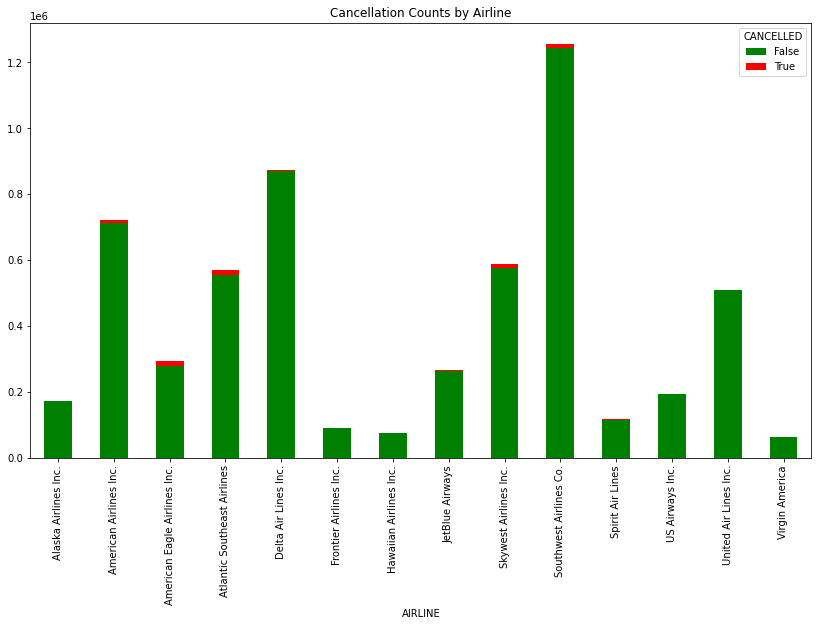

In [35]:
#adapted from StudentExampleLab1
cancel_count = pd.crosstab(df['AIRLINE'], df['CANCELLED'].astype(bool))
cancel_count.plot(kind='bar', stacked=True, color=['green','red'], figsize=(14, 8))

plt.title('Cancellation Counts by Airline')
plt.show()

Because the number of cancellations is so few, it's not useful to visualize in this way. Let's see if there's a larger difference based on delay.

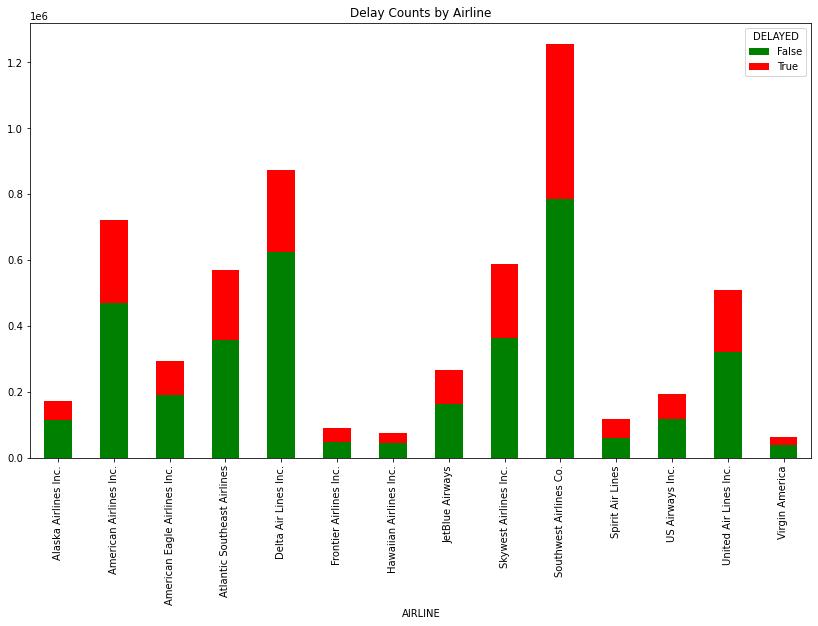

In [36]:
#create new column where the arrival_delay > 0 means it's delayed(=1) and if <= 0 it's not delayed(=0)
get_delay = lambda x: 0 if x <= 0 else 1
df['DELAYED'] = df.ARRIVAL_DELAY.apply(get_delay)

delay_count = pd.crosstab(df['AIRLINE'], df['DELAYED'].astype(bool))
#print(delay_count.head())
delay_count.plot(kind='bar', stacked=True, color=['green','red'], figsize=(14, 8))

plt.title('Delay Counts by Airline')
plt.show()

Southwest has the highest overall number of flights but does appear to also have a high amount of delays. As a proportion of total flights, Delta appears to have some of the fewest delays.

In [37]:
#Let's further explore the delay types - average delay by type based on airline
df.query('ARRIVAL_DELAY > 0').groupby('AIRLINE').agg({'AIR_SYSTEM_DELAY': 'mean', 
                        'SECURITY_DELAY': 'mean',
                        'AIRLINE_DELAY': 'mean', 
                        'LATE_AIRCRAFT_DELAY': 'mean',
                       'WEATHER_DELAY': 'mean'})

AIR_SYSTEM_DELAY  SECURITY_DELAY  AIRLINE_DELAY  \
AIRLINE                                                                         
Alaska Airlines Inc.                      5.29            0.10           6.10   
American Airlines Inc.                    6.98            0.06          10.92   
American Eagle Airlines Inc.              8.99            0.07          10.19   
Atlantic Southeast Airlines               7.92            0.00          11.09   
Delta Air Lines Inc.                      7.09            0.02          10.79   
Frontier Airlines Inc.                   14.10            0.00           8.41   
Hawaiian Airlines Inc.                    0.21            0.01           6.51   
JetBlue Airways                           9.72            0.11          10.53   
Skywest Airlines Inc.                     6.00            0.04           9.19   
Southwest Airlines Co.                    3.55            0.03           8.14   
Spirit Air Lines                         16.55            0.09           8.28   
US Airways Inc.                           7.89            0.08           8.34   
United Air Lines Inc.                     8.11            0.01          11.89   
Virgin America                            9.92            0.08           5.41   

                              LATE_AIRCRAFT_DELAY  WEATHER_DELAY  
AIRLINE                                                           
Alaska Airlines Inc.                         6.70           0.68  
American Airlines Inc.                      11.23           1.85  
American Eagle Airlines Inc.                13.69           3.89  
Atlantic Southeast Airlines                 12.33           0.79  
Delta Air Lines Inc.                         8.52           2.40  
Frontier Airlines Inc.                      15.38           0.52  
Hawaiian Airlines Inc.                       4.20           0.38  
JetBlue Airways                             13.90           1.14  
Skywest Airlines Inc.                       12.90           1.13  
Southwest Airlines Co.                      13.41           1.16  
Spirit Air Lines                            12.33           0.78  
US Airways Inc.                              6.86           0.92  
United Air Lines Inc.                       14.63           1.75  
Virgin America                              10.57           1.46

- Spirit Airlines has the largest average delay due to air system at 16.55 minutes
- JetBlue Airways has the highest average security delay at 0.11 minutes, but this is still fairly minor
- The airlines that exceed an average of 10 minutes for airline delays are American, Atlantic Southeast (now defunct), Delta, JetBlue, and United.
- The clear winner for late aircraft delays average is Frontier at just over 15.38 minutes
- Despite being the most common cause of delay, the highest average weather delay is only 3.89 minutes from American Eagle

In [38]:
#what is percentage of flights delayed

#create new column where the arrival_delay > 0 means it's delayed(=1) and if <= 0 it's not delayed(=0)
get_delay = lambda x: 0 if x <= 0 else 1
df['DELAYED'] = df.ARRIVAL_DELAY.apply(get_delay)

#adapated from https://blog.softhints.com/pandas-count-percentage-value-column/
s = df.DELAYED
counts = s.value_counts()
percent = s.value_counts(normalize=True)
percent100 = s.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
pd.DataFrame({'counts': counts, 'per100': percent100})

counts per100
0  3702270  64.0%
1  2086895  36.0%

Amongst all airlines, about 36% of the total flights from this dataset experienced some sort of delay. This is compared to the 1.3% of flights that were cancelled. This equates to about 2.1 million flights. 

## Visualize Attributes

#### <font color='red'>Feedback: This section is weak overall Insufficient analysis. Charts missing analysis. Can barely read Cancellation Heat Map. Missing proper analysis of this chart. Some months and hot spots not addressed. Important: Interpret the implications for each visualization. Explain for each attribute why the chosen visualzation is appropriate.</font>

### Flights by Airline

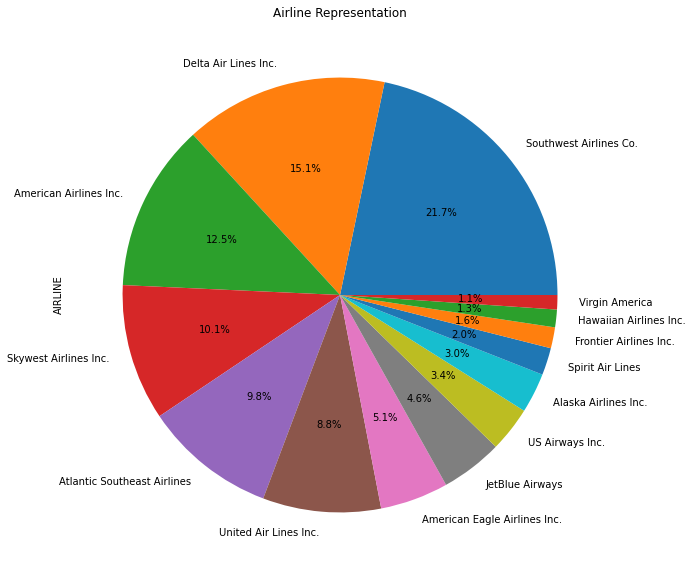

In [39]:
df['AIRLINE'].value_counts().plot.pie(autopct='%1.1f%%', figsize=(10,10))
plt.title('Airline Representation')
plt.show()

Text(0, 0.5, 'Airline')

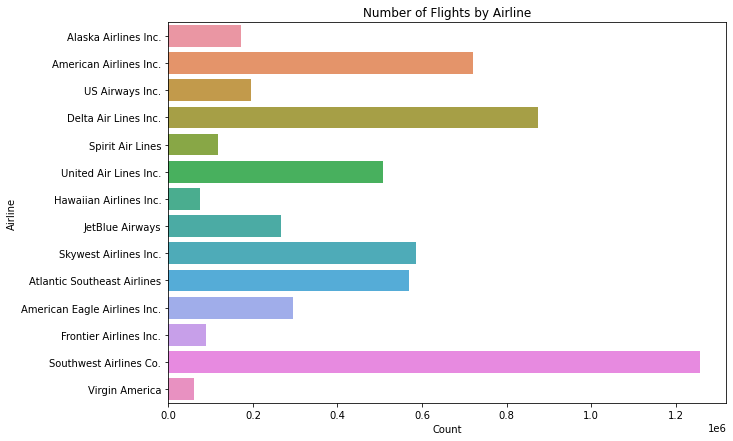

In [40]:
#adapted from https://www.dataforeverybody.com/countplot-seaborn-order-size-values/

countplt, ax = plt.subplots(figsize = (10,7))
ax = sns.countplot(y = 'AIRLINE', data = df)

# Chart and axes titles
ax.set_title('Number of Flights by Airline',fontsize = 12 )
ax.set_xlabel('Count', fontsize = 10)
ax.set_ylabel('Airline', fontsize = 10)

In this data set, Southwest has above and beyond the highest number of flights at over 1.2 million (21.7%). Virgin America had the fewest percentage of flights (1.1%).

### Flights by Day of Week

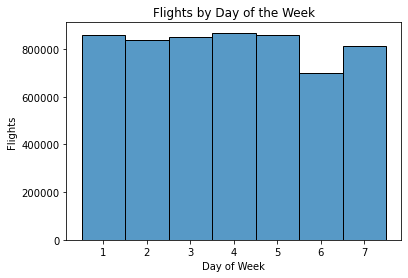

In [41]:
sns.histplot(df, x = 'DAY_OF_WEEK', discrete=True)

plt.title('Flights by Day of the Week')
plt.xlabel('Day of Week')
plt.ylabel('Flights')

plt.show()

Interestingly, day 6 (Saturday) has more than 100,000 fewer flights than the other days of the week. We would have thought that the counts across days would be more evenly distributed, but upon further reflection that makes sense. Weekday travel for business is fairly consistent. Travelers flying over the weekend would most likely fly out prior to the weekend if possible in order to maximize their weekend time. 

### Arrival Delay by Airline

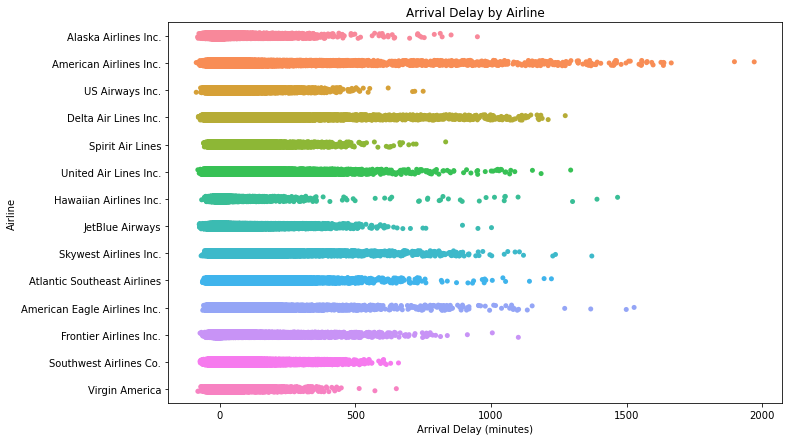

In [42]:
# Set plot size
fig, scatter = plt.subplots(figsize = (11,7))

# Arrival delay by airline
sns.stripplot(x='ARRIVAL_DELAY', y='AIRLINE',
              data=df, dodge=True, jitter=True).set(title='Arrival Delay by Airline')

plt.xlabel('Arrival Delay (minutes)')
plt.ylabel('Airline')

plt.show()

Visualizing the arrival delay in minutes by airline, all of the airlines had some amount of flights that departed early (left of the '0' mark on the x-axis). 

In general, Hawaiian Airlines Inc. and Virgin America appear to have the smallest arrival delays of all of the airlines. American Airlines Inc. (AAL) shows the widest range of delays with a strong concentration of delays between 0 and 1,000 minutes (about 0-16 hours) that then tapers off around 1,700 minutes (about 28 hours) and finally two outliers close to 2,000 minutes (about 33 hours).

### Cancellation Heat Map

In [43]:
#heat map of cancellations by Month & Day of Week from randomly sampled 5,000 rows
df_subset = df.sample(n=5000)

alt.Chart(df_subset).mark_rect().encode(
    x='DAY_OF_WEEK:O',
    y='MONTH:O',
    color='sum(CANCELLED):Q'
)

alt.Chart(...)

Based on this heatmap, there are more cancellations within the months of February and March, and the cancellations typically tend to fall on Day 1 (or Monday).

## Explore Joint Attributes

#### <font color='red'>Feedback: Correlation Plot - Explain any interesting relationships.</font>

### Correlation Plot

<AxesSubplot:>

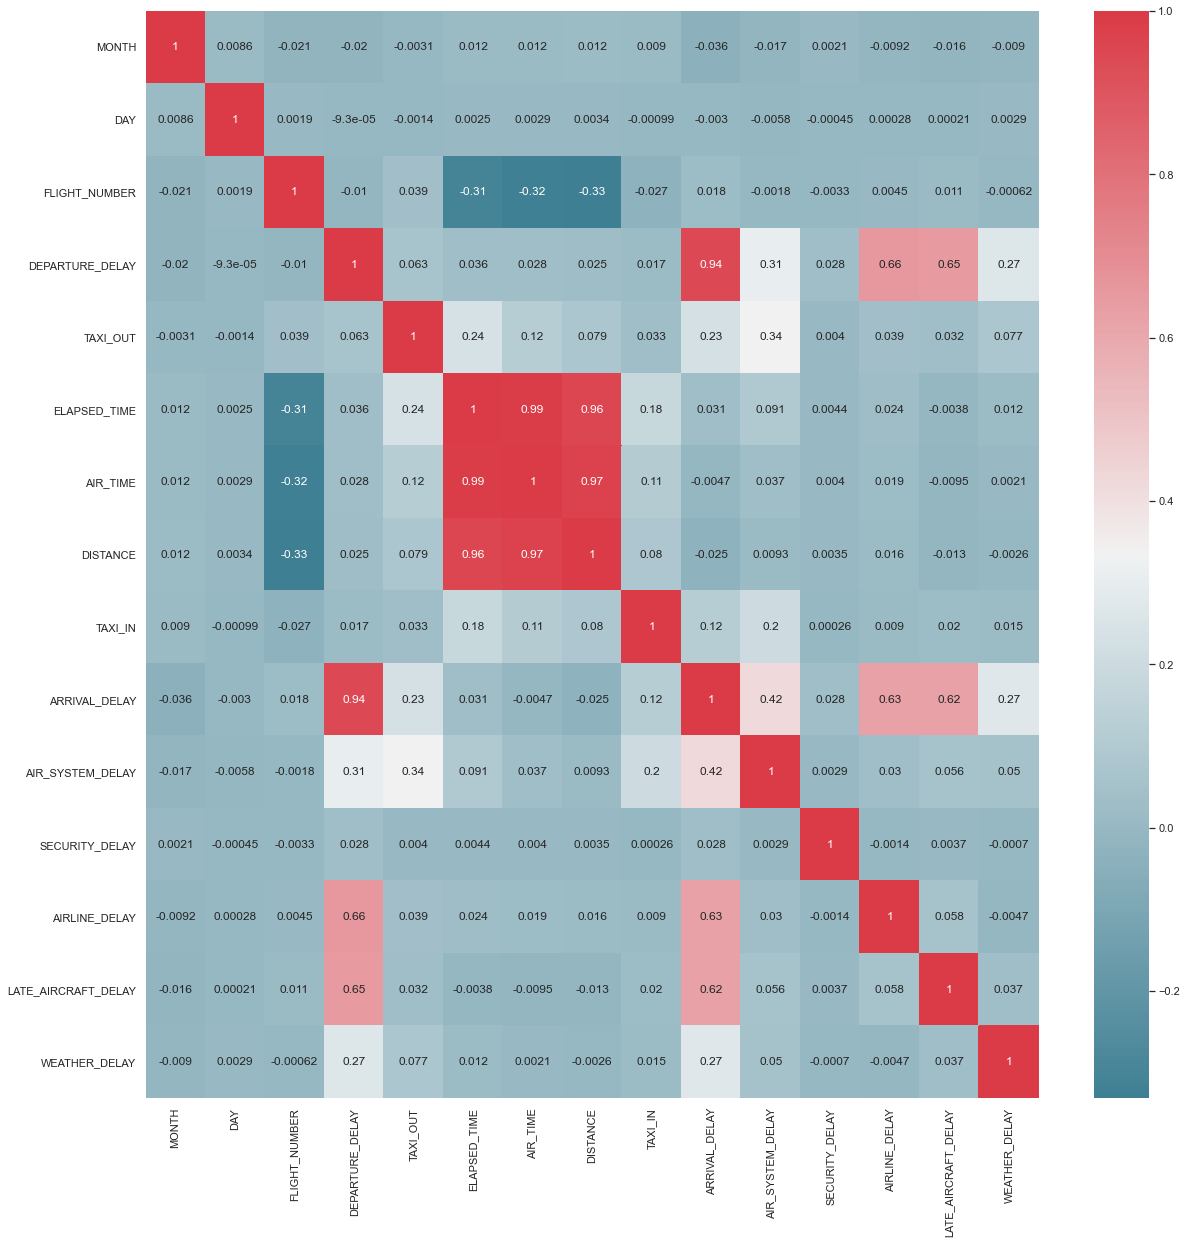

In [44]:
# Examine correlation visually using Seaborn. (Code adapted from 02. Data Visualization.ipynb)
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.set(style = "darkgrid") # one of the many styles to plot using

f, ax = plt.subplots(figsize = (20, 20))

#subset for continuous variables only
num = df[['MONTH', 'DAY','FLIGHT_NUMBER',
          'DEPARTURE_DELAY','TAXI_OUT',
          'ELAPSED_TIME','AIR_TIME','DISTANCE',
          'TAXI_IN','ARRIVAL_DELAY','AIR_SYSTEM_DELAY',
          'SECURITY_DELAY','AIRLINE_DELAY',
          'LATE_AIRCRAFT_DELAY','WEATHER_DELAY']]

sns.heatmap(num.corr(), cmap=cmap, annot = True)

`ELAPSED_TIME`, `AIR_TIME`, and `DISTANCE` are all highly correlated to each other. This makes sense as these values are all dependent on one another. Additionally, `DEPARTURE_DELAY` and `ARRIVAL_DELAY` are also highly correlated. For the purposes of additional visualizations, we will keep these in for now and review which variables to remove within our training parameters.

### Relationship Between Delays

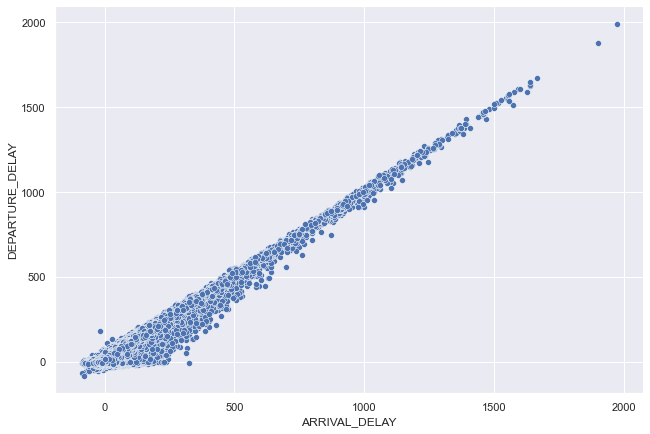

In [45]:
#check relationship between arrival delay and departure delay
sns.relplot(x="ARRIVAL_DELAY", y="DEPARTURE_DELAY", data=df, height=6, aspect=1.5)

As expected from the correlation plot, there is a strong relationship between the arrival delay and the departure delay. At lower arrival or depature delays, the relationship is a bit weaker compared to when the delays are longer. Let's see if we can see anything interesting if we just look at delays < 500 minutes.

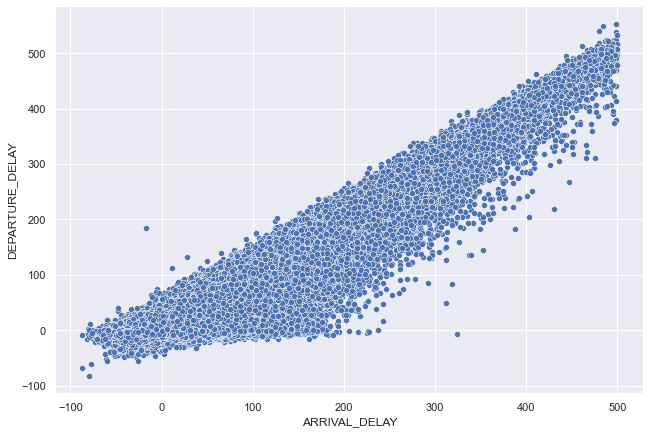

In [46]:
#check relationship between arrival delay and departure delay < 500 minutes

sns.relplot(x="ARRIVAL_DELAY", y="DEPARTURE_DELAY", data=df[df.ARRIVAL_DELAY < 500], height=6, aspect=1.5)

Not much useful here either, just a clump of data with a strong correlation. Let's check on the negative time to see if there is a different relationship for flights that depart or arrive early.

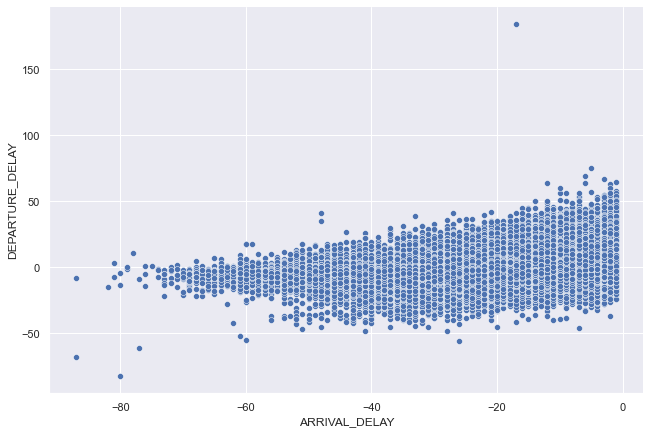

In [47]:
#check relationship between early flights

sns.relplot(x="ARRIVAL_DELAY", y="DEPARTURE_DELAY", data=df[df.ARRIVAL_DELAY < 0], height=6, aspect=1.5)

When the arrival delay is negative (meaning the flight arrives early), the relationship is not quite as strong. This shows that the flights can still arrive early if they depart a bit late.

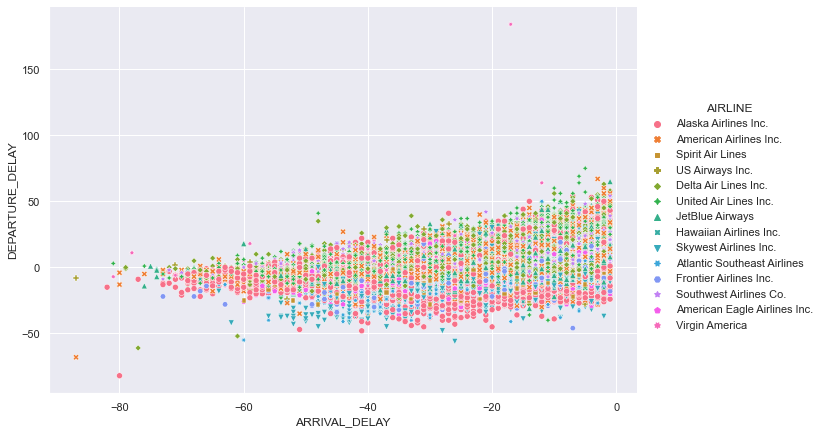

In [48]:
#color code by airline to see if any stick out

sns.relplot(x="ARRIVAL_DELAY", y="DEPARTURE_DELAY", hue = "AIRLINE", style = "AIRLINE", 
            data=df[df.ARRIVAL_DELAY < 0], height=6, aspect=1.5)

Based on the sheer amount of data and clustering, the only noticeable observation is Alaska Airlines tending to fall towards the bottom of the distribution - both leaving and arriving earlier than most.

### Arrival Delay Based on Distance

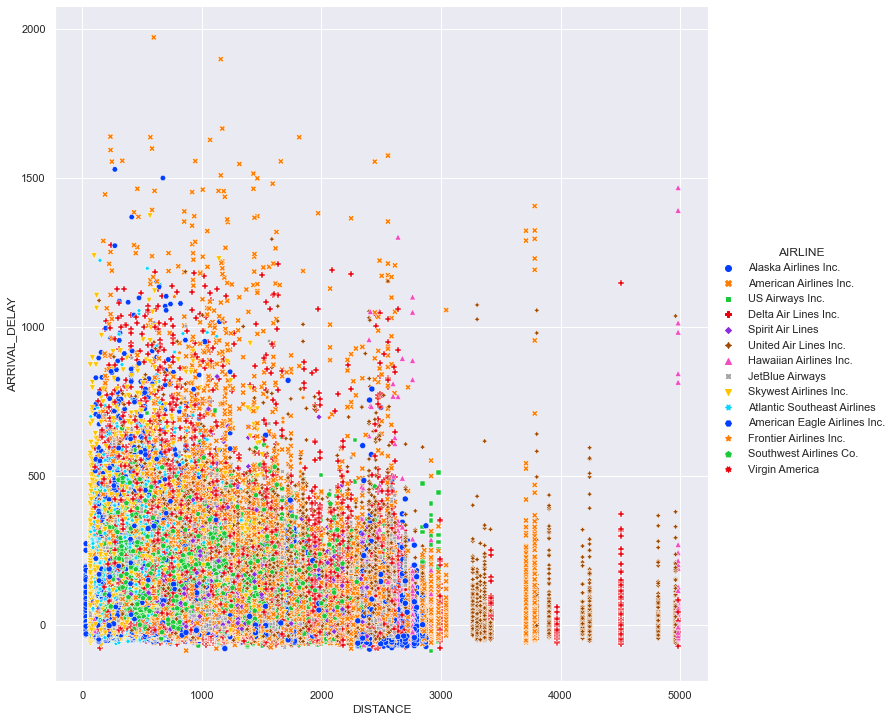

In [49]:
sns.relplot(x="DISTANCE", y="ARRIVAL_DELAY", hue = 'AIRLINE', 
            palette = "bright", style = "AIRLINE", data=df, height=10)

We see lots of outliers at the shorter distances with American in particular in terms of arrival delays. United, Hawaiian, and Delta look to be the airlines that typically have the longest flight distances just in general. 

### Tail Number and Delays

In [50]:
#Investigate tail number and delays (do we have any planes in particular that are a problem?)

#subset to the top 10 worst offenders
plane = df.groupby('TAIL_NUMBER').agg({'ARRIVAL_DELAY': 'mean'})
plane.sort_values('ARRIVAL_DELAY', ascending=False).head(10)

ARRIVAL_DELAY
TAIL_NUMBER               
N79011              236.67
N128UA              183.67
N843MH              175.50
N37018              161.25
N121UA              161.00
N180UA              108.00
N69020              104.50
N370AA               88.97
N78004               86.80
N670US               81.27

The above tail numbers have the highest average delay time in minutes. Let's subset to these to see if there are outliers dragging up the mean.

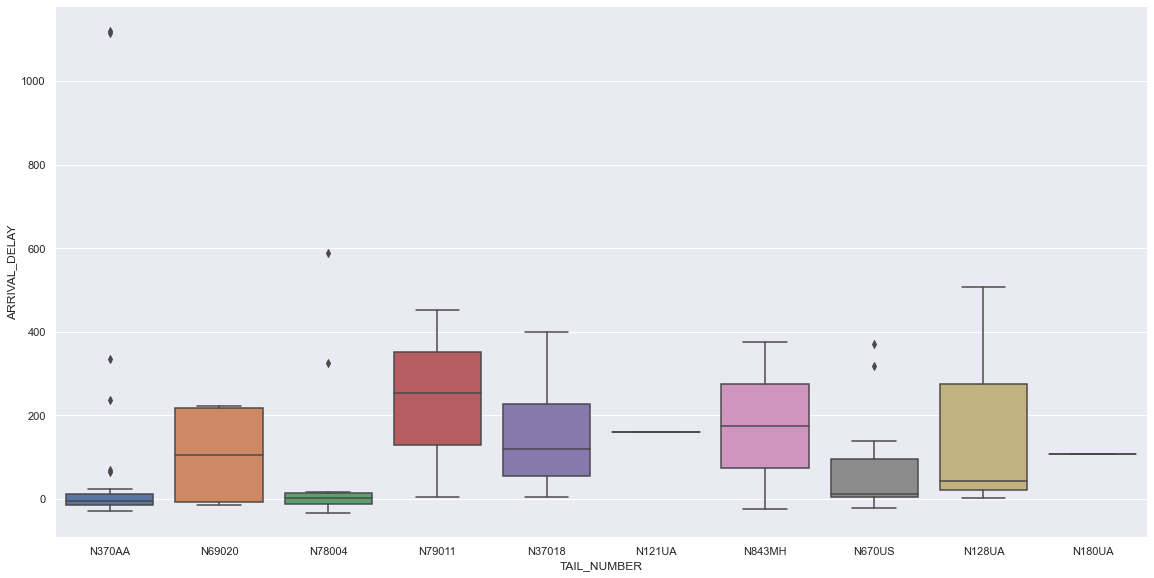

In [51]:
tails = ['N79011', 'N128UA', 'N843MH', 'N37018', 'N121UA', 'N180UA', 'N69020', 'N370AA', 'N78004', 'N670US'] 

bad_planes = df[df['TAIL_NUMBER'].isin(tails)]
#bad_planes.head()

sns.catplot(x="TAIL_NUMBER", y="ARRIVAL_DELAY", kind="box", data=bad_planes, height=8, aspect=2)

N370AA is definitely skewed by outliers. N121UA and N180UA are also only one data point. From looking at the boxplots, the worst plane appears to be N79011. Let's see what airline this is from.

In [52]:
#pd.set_option('display.max_columns', None)
bad_planes[bad_planes.TAIL_NUMBER == 'N79011']

YEAR  MONTH  DAY  DAY_OF_WEEK AIRLINE_CODE  FLIGHT_NUMBER TAIL_NUMBER  \
164109  2015      1   11            7           UA           1178      N79011   
174207  2015      1   12            1           UA           1558      N79011   
566254  2015      2    7            6           UA           1558      N79011   

       ORIGIN_AIRPORT DESTINATION_AIRPORT SCHEDULED_DEPARTURE DEPARTED  \
164109            EWR                 IAH 1900-01-01 16:30:00        1   
174207            IAH                 EWR 1900-01-01 10:30:00        1   
566254            IAH                 EWR 1900-01-01 10:30:00        1   

        DEPARTURE_DELAY  TAXI_OUT WHEELS_OFF SCHEDULED_TIME  ELAPSED_TIME  \
164109            10.00     13.00          1            236        231.00   
174207           454.00     32.00          1            200        197.00   
566254           262.00     12.00          1            200        192.00   

        AIR_TIME  DISTANCE WHEELS_ON  TAXI_IN   SCHEDULED_ARRIVAL ARRIVED  \
164109    203.00      1400         1    15.00 1900-01-01 19:26:00       1   
174207    155.00      1400         1    10.00 1900-01-01 14:50:00       1   
566254    169.00      1400         1    11.00 1900-01-01 14:50:00       1   

        ARRIVAL_DELAY  DIVERTED  CANCELLED CANCELLATION_REASON  \
164109           5.00         0          0                   N   
174207         451.00         0          0                   N   
566254         254.00         0          0                   N   

        AIR_SYSTEM_DELAY  SECURITY_DELAY  AIRLINE_DELAY  LATE_AIRCRAFT_DELAY  \
164109              0.00            0.00           0.00                 0.00   
174207              0.00            0.00         451.00                 0.00   
566254              0.00            0.00           0.00               254.00   

        WEATHER_DELAY                AIRLINE FLIGHT_DATE  DEPARTURE_DELAY_log  \
164109           0.00  United Air Lines Inc.  2015-01-11                 2.40   
174207           0.00  United Air Lines Inc.  2015-01-12                 6.12   
566254           0.00  United Air Lines Inc.  2015-02-07                 5.57   

        ARRIVAL_DELAY_Log  DISTANCE_log  TAXI_IN_Log  ELAPSED_TIME_log  \
164109               1.79          7.24         2.77              5.45   
174207               6.11          7.24         2.40              5.29   
566254               5.54          7.24         2.48              5.26   

        AIR_TIME_log  DELAYED  
164109          5.32        1  
174207          5.05        1  
566254          5.14        1

This particular plane is from United Airlines, and has only three flights in the database. Interestingly enough, it was the same route each time (Newark to Houston or vice versa).

## Explore Attributes and Class

#### <font color='red'>Feedback: Sufficient...</font>

### Cancellations Over Time

We were interested in whether there is a trend in cancellations by day of the week or month. We expected to see an increase in cancellations for winter months, but were suprised to see they are relatively the same each month. The number of flights that were not cancelled(0), was relatively consistent from month to month, but the number of cancellations varied monthly, with February being the highest recorded cancellations, most likely due to weather conditions. We plan to explore this further in the future.

<AxesSubplot:xlabel='CANCELLED', ylabel='MONTH'>

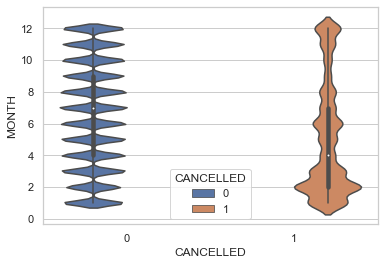

In [53]:
sns.set_theme(style="whitegrid")
cancelbymonth = flights.filter(['MONTH', 'CANCELLED']);
#sns.violinplot(x ='MONTH', y="CANCELLED", data = cancelbyairline, scale="count", split=True, palette="Set2")
sns.violinplot(x ='CANCELLED', y="MONTH", data = cancelbymonth, scale_hue=True, hue="CANCELLED")

### Departure vs. Arrival Delay

Pilots often try to make up time in the air, by flying higher, faster or taking a different route. In comparing the two boxplots below, we can see that the data spread appears similar between charts, indicating that if a flight departs delayed, regardless of the delay reason, it will most likely be delayed at arrival.

<AxesSubplot:xlabel='MONTH', ylabel='DEPARTURE_DELAY'>

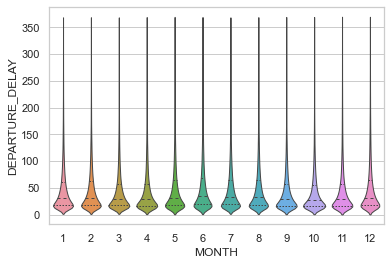

In [54]:
sns.violinplot(x = 'MONTH', y = 'DEPARTURE_DELAY', data = df.query('DEPARTURE_DELAY > 10 & DEPARTURE_DELAY < 360'),
               inner="quart", linewidth=1, split=True)

The chart above shows the departure delay for flights by month and the chart below shows arrival delays by month. We chose to focus on the interval of 15-320 minutes late. Flights are often one to two minutes off in arrival, so including those values skewed the data significantly.

<AxesSubplot:xlabel='MONTH', ylabel='ARRIVAL_DELAY'>

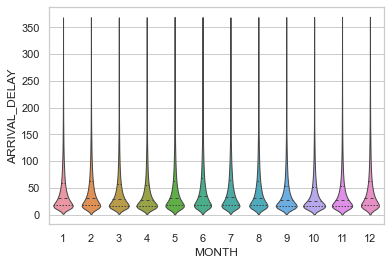

In [55]:
sns.violinplot(x = 'MONTH', y = 'ARRIVAL_DELAY', data = df.query('ARRIVAL_DELAY > 10 & ARRIVAL_DELAY < 360'),
               inner="quart", linewidth=1, split=True)

## New Features 

#### <font color='red'>Feedback: Great!</font>

The New Features that are being considered to be added are listed below:

- **Region**: This would be a bucket created from using the Departing Airport Data to determin what region the Airport is in and classify it accordingly. ie (Central US, Midwest US, ect.)

- **Time of Day**: This bucket would be created from the SCHEDULED_DEPARTURE variable to catagorize them by Early Morning, Morning, Afternoon, Evening. 

- **Arrival Status**: This would be created from using the Arrival_Delays variable to catagorize from early arrivals to having greater that an hour delay and beyond.

There is also consideration to pair the data with Historical Nation Weather from Climate.gov or https://openweathermap.org/history to get weather that impacted delays to further determine the cause of the weather impacted delays. 

## Exceptional Work

#### <font color='red'>Feedback: Good job on PCA</font>

### Principal Components Analysis

In [56]:
# Look at what continuous variables we have to work with
df.select_dtypes(np.number).head()

YEAR  MONTH  DAY  DAY_OF_WEEK  FLIGHT_NUMBER  DEPARTURE_DELAY  TAXI_OUT  \
0  2015      1    1            4             98           -11.00     21.00   
1  2015      1    1            4           2336            -8.00     12.00   
2  2015      1    1            4            840            -2.00     16.00   
3  2015      1    1            4            258            -5.00     15.00   
4  2015      1    1            4            135            -1.00     11.00   

   ELAPSED_TIME  AIR_TIME  DISTANCE  TAXI_IN  ARRIVAL_DELAY  DIVERTED  \
0        194.00    169.00      1448     4.00         -22.00         0   
1        279.00    263.00      2330     4.00          -9.00         0   
2        293.00    266.00      2296    11.00           5.00         0   
3        281.00    258.00      2342     8.00          -9.00         0   
4        215.00    199.00      1448     5.00         -21.00         0   

   CANCELLED  AIR_SYSTEM_DELAY  SECURITY_DELAY  AIRLINE_DELAY  \
0          0              0.00            0.00           0.00   
1          0              0.00            0.00           0.00   
2          0              0.00            0.00           0.00   
3          0              0.00            0.00           0.00   
4          0              0.00            0.00           0.00   

   LATE_AIRCRAFT_DELAY  WEATHER_DELAY  DEPARTURE_DELAY_log  ARRIVAL_DELAY_Log  \
0                 0.00           0.00                 0.00               0.00   
1                 0.00           0.00                 0.00               0.00   
2                 0.00           0.00                 0.00               1.79   
3                 0.00           0.00                 0.00               0.00   
4                 0.00           0.00                 0.00               0.00   

   DISTANCE_log  TAXI_IN_Log  ELAPSED_TIME_log  AIR_TIME_log  DELAYED  
0          7.28         1.61              5.27          5.14        0  
1          7.75         1.61              5.63          5.58        0  
2          7.74         2.48              5.68          5.59        1  
3          7.76         2.20              5.64          5.56        0  
4          7.28         1.79              5.38          5.30        0

In [57]:
# Select columns for PCA
df_numeric = df[['DEPARTURE_DELAY', 'TAXI_OUT', 'ELAPSED_TIME', 'AIR_TIME', 
                 'DISTANCE', 'TAXI_IN', 'ARRIVAL_DELAY', 'AIR_SYSTEM_DELAY', 
                 'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 
                 'WEATHER_DELAY']]

In [58]:
df_numeric.shape

(5789165, 12)

In [59]:
# Source: https://towardsdatascience.com/principal-component-analysis-pca-with-scikit-learn-1e84a0c731b0
# Standardize the features
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Create the object
scaler = StandardScaler()

# Calculate the mean and standard deviation
scaler.fit(df_numeric)
df_pca_scaled = scaler.transform(df_numeric)

In [60]:
# Calculate the PCA that explains 95% of the variance
pca_95 = PCA(n_components=0.95, random_state=2015)
pca_95.fit(df_pca_scaled)
df_pca_95 = pca_95.transform(df_pca_scaled)

# Display the PCA values
np.cumsum(pca_95.explained_variance_ratio_*100)

array([26.21334664, 50.60401332, 61.49305964, 69.86791782, 78.20215475,
       86.2577998 , 93.92816358, 99.19100697])

The 7th principal component brings us to 93.928%.

Text(0, 0.5, 'Explained Variance')

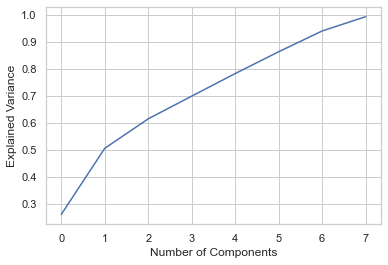

In [61]:
# Plot PCA results
plt.plot(np.cumsum(pca_95.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')

The above skree plot shows a sharp uptick in explained variance between PC1 and PC2, then a steady rise until PC7 which brings the total explained variance to 93.928%. 

In [62]:
df_post_pca = pd.DataFrame(df_pca_95, columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8'])
df_post_pca['Cancelled'] = df.CANCELLED
df_post_pca.head()

PC1   PC2   PC3   PC4   PC5   PC6   PC7   PC8  Cancelled
0 0.22 -1.71 -0.08  0.46 -0.05 -0.64 -0.32 -0.15       0.00
1 1.53 -3.30 -1.02  0.35 -0.05 -0.19 -0.16  0.64       0.00
2 2.05 -3.27 -0.35 -0.16 -0.01  0.39  0.17 -0.03       0.00
3 1.70 -3.31 -0.59  0.07 -0.03  0.10  0.01  0.21       0.00
4 0.41 -1.90 -0.73  0.18 -0.03 -0.03 -0.04  0.50       0.00

#### Plot PCA with n_components = 2

Text(0, 0.5, 'Second Principal Component')

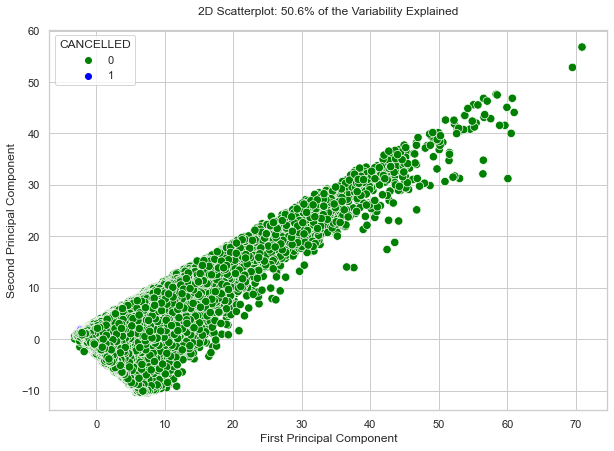

In [63]:
plt.figure(figsize=(10, 7))
sns.scatterplot(x=df_pca_95[:, 0], y=df_pca_95[:, 1], s=70,
               hue=df.CANCELLED, palette=['green', 'blue'])

plt.title("2D Scatterplot: 50.6% of the Variability Explained", pad=15)
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")

Due to the significant class imbalance in cancellations, the only visible points on the scatterplot come from flights that weren't cancelled. Our data set does not contain a large number of continuous values; based on these results, PCA may not be the most appropriate tool for dimensionality reduction. Additional exploration will be required if we desire to reduce the number of variables. Possible solutions might include random forest to check variable importance or iteration through variable selection. 